In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob

import cv2
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab Notebooks/CCS Prediction/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/CCS Prediction/Data/'
fname = 'Training data'
data = pd.read_csv(path + fname + '.csv')
# skiprows=1

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
Seq = np.array(data["Sequence"])
Cha = np.array(data["Charge"])
CCS = np.array(data["CCS"])
# Seq.head()

In [ ]:
def string_vectorizer(strng, alphabet='ARNDCQEGHILKMFPSTWYV'):
    vector = [[0 if char != letter else 1 for char in alphabet] 
                  for letter in strng]
    return vector

array = np.array(Seq)
len = np.shape(array)[0]
seq_vec = [[]]
for i in range(0,len):
    array[i] = array[i].ljust(60,'*')
    seq_vec.append(np.reshape(string_vectorizer(array[i]),1200, order = 'F'))

seq_vec.pop(0)
np.shape(seq_vec)


(51877, 1200)

In [ ]:
np.random.seed(123)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split


In [ ]:
feats = np.array(seq_vec)
X = np.array(Cha)
Y = np.array(CCS)

In [ ]:
feat = Input(shape=(1200,))
charge = Input(shape=(1,))

# the first branch operates on the first input
x = Dense(200, activation="relu")(feat)
x = BatchNormalization()(x)
x = Dense(200, activation="relu")(x)
x = Dense(200, activation="relu")(x)
x = Dense(1, activation="linear")(x)
x = Model(inputs=feat, outputs=x)

# combine the output of the two branches
combined = concatenate([x.output, charge])

# apply a FC layer and then a regression prediction on the combined outputs
z = Dense(200, activation="relu")(combined)
# z = BatchNormalization()(z)
z = Dense(1, activation="linear")(z)

model = Model(inputs=[x.input, charge], outputs=z)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1200)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          240200      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200)          800         dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          40200       batch_normalization[0][0]        
____________________________________________________________________________________________

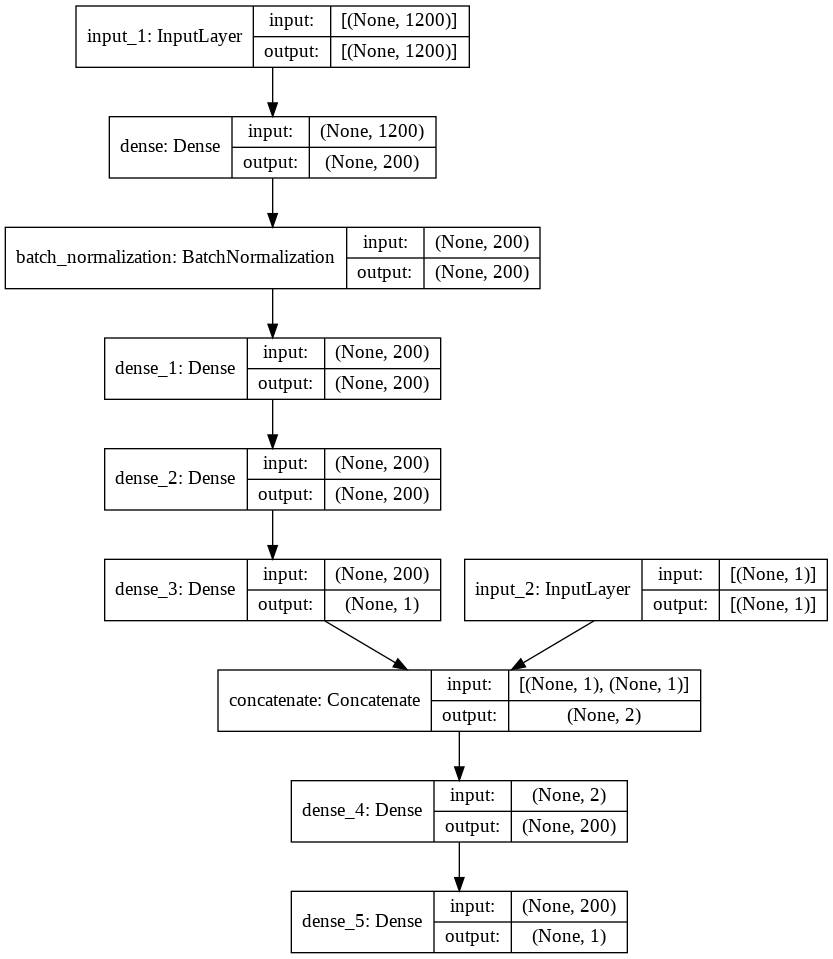

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

def scheduler(epoch, lr):
    if epoch < 20:
      return lr
    else:
      return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
opt = keras.optimizers.Adam(learning_rate=0.005)
# lr_metric = get_lr_metric(opt)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
history = model.fit(
	x=[feats, X], y=Y,	validation_split= 0.2,epochs=50, batch_size = 256, shuffle=True, callbacks=[callback])
# validation_data=([feats_val, X_val], Y_val)
# make predictions on the testing data
print("[INFO] predicting ion mobiliities...")
# preds = model.predict([feats_val, X_val])

[INFO] training model...
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.004999999888241291.
163/163 [==============================] - 2s 7ms/step - loss: 37.9258 - val_loss: 39.5310
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.004999999888241291.
163/163 [==============================] - 1s 5ms/step - loss: 7.7780 - val_loss: 12.7318
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004999999888241291.
163/163 [==============================] - 1s 5ms/step - loss: 6.3962 - val_loss: 5.2629
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.004999999888241291.
163/163 [==============================] - 1s 5ms/step - loss: 5.8415 - val_loss: 5.9021
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.004999999888241291.
163/163 [==============================] - 1s 5ms/step - loss: 5.4394 - val_loss: 5.8035
Epoch 6/50

Epoch 00006: LearningRateScheduler reduc

In [ ]:
preds = model.predict([feats, X])

In [ ]:
# def plot_loss(history):
#   plt.plot(history.history['loss'], label='loss')
#   plt.plot(history.history['val_loss'], label='val_loss')
#   plt.ylim([0, 5])
#   plt.xlabel('Epoch')
#   plt.ylabel('Error')
#   plt.legend()
#   plt.grid(True)

# plot_loss(history)

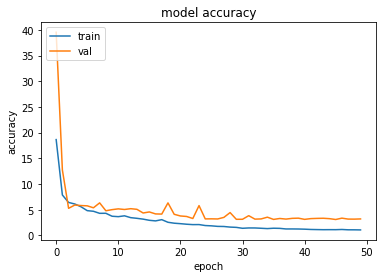

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

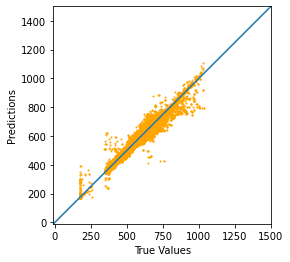

In [ ]:
preds = preds.flatten()
a = plt.axes(aspect='equal')
plt.scatter(Y, preds, s = 1, c='orange')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-10, 1500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
# model.save("First reg model")
# model.save('/content/drive/My Drive/{}'.format(FOLDERNAME))

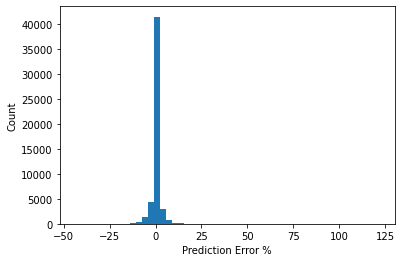

In [ ]:
error = (preds - Y)/Y*100
plt.hist(error, bins=50)
plt.xlabel('Prediction Error %')
_ = plt.ylabel('Count')

In [ ]:
np.median(abs(error))

0.35493718889646747

Trying model on unseen data:

In [ ]:
# model = keras.models.load_model("2021-02-04")

In [ ]:
test_path = '/content/drive/My Drive/Colab Notebooks/CCS Prediction/Data/'
testname = 'Mouse FDR1'
Tdata = pd.read_csv(test_path + testname + '.csv')

Tseq = Tdata["Sequence"]
Tattributes = Tdata["Charge"]
Tlabel = Tdata["CCS"]

Tarray = np.array(Tseq)
Tlen = np.shape(Tarray)[0]
Tseq_feat = [[]]
for i in range(0,Tlen):
    Tarray[i] = Tarray[i].ljust(60,'*')
    Tseq_feat.append(np.reshape(string_vectorizer(Tarray[i]),1200, order = 'F'))
Tseq_feat.pop(0)

Tseq = np.array(Tseq_feat)
Tattribute = np.array(Tattributes)
TY = np.array(Tlabel)

print("[INFO] predicting ion mobiliities...")
Tpreds = model.predict([Tseq, Tattribute])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (59) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[INFO] predicting ion mobiliities...


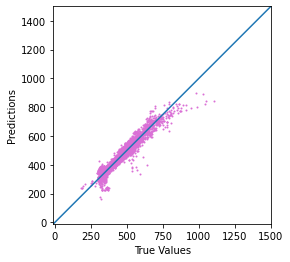

In [ ]:
Tpreds = Tpreds.flatten()
shift = 11.6
Tpreds = Tpreds - shift
a = plt.axes(aspect='equal')
plt.scatter(TY, Tpreds, s = 1, c='orchid')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-10, 1500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

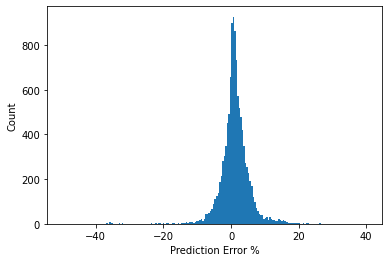

In [ ]:
Terror = (Tpreds - TY)/TY*100
# Terror = (Tpreds - TY)
plt.hist(Terror, bins=200)
plt.xlabel('Prediction Error %')
# plt.xlim([-100,100])
_ = plt.ylabel('Count')

In [ ]:
np.median(abs(Terror))

2.0222389779321013

In [ ]:
from scipy import stats
Val = stats.pearsonr(Y, preds)
Test = stats.pearsonr(TY,Tpreds)
print('Seen data:' + str(Val[0]))
print('Unseen data:' + str(Test[0]))

Seen data:0.9884924589008808
Unseen data:0.9707761144479264


In [ ]:
(np.absolute(Terror) < 10).sum()/np.shape(Terror)[0]

0.9612356147789218

In [ ]:
TY.size

11557

In [ ]:
print(Tpreds[357])

470.85712


In [ ]:
TY[357]

454.75709969999997